<a href="https://colab.research.google.com/github/SomethingStinkyyy/NASART/blob/main/NASART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title SETUP
#checking nvidia memory and relevant messages/alerts
nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv #nvidia query to monitor gpu and store the available memory as a list to a variable

gpu_memory = int(nvidia_output[0]) #first result of the nvidia_output list is assigned to a variable

if gpu_memory <14000: #if the value of gpu_memory is less than 14000
  output.eval_js ('new Audio("https://upload.wikimedia.orga/wikipedia/commons/0/05/Beep-09.ogg").play()') #eval statement to play a sound file
  warning_string = f"--> GPU check: ONLY {gpu_memory} MiB available: Please use low quality or low resolution <--" #warning message text in a variable
  print(warning_string) #prints the warning message
  output.eval_js('alert("Warning - low GPU (see message)")') #eval statement to print an alert to check the message
else: #if gpu_memory is greater than 14000
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

#Installation
!pip install torch==1.9.0+cu102 torchtext==0.10.0 torchvision==0.10.0+cu102 torch-optimizer==0.1.0 -f https://download.pytorch.org/whl/torch/ -f https://download.pytorch.org/whl/torchvision/

!git clone https://github.com/openai/CLIP

#!pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!rm -Rf pixray #removes the pixray directory
!git clone https://github.com/dribnet/pixray
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia==0.6.1
!pip install imageio-ffmpeg
!pip install einops
!pip install torch-optimizer
!pip install easydict
!pip install braceexpand
!pip install git+https://github.com/pvigier/perlin-numpy
!mkdir -p steps
!mkdir -p models


  #ClipDraw depositories (optional?)
!pip install svgwrite #to write SVG files
!pip install svgpathtools
!pip install cssutils #to manipulate CSS values in python code
!pip install numba
!pip install torch-tools #for plotting data with TensorFlow
!pip install visdom

!pip install gradio==2.5.1 #gradio for web ui


import sys
sys.path.append("pixray")

print("Setup Completed! Have fun with NASART!")


GPU check: 15360 MiB available: this should be fine
Looking in links: https://download.pytorch.org/whl/torch/, https://download.pytorch.org/whl/torchvision/
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu102 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.7/367.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 973.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 958.4 kB/s eta 0:00:00
  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-qvopemh1
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-qvopemh1
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done
  Created wheel for perlin-numpy: filename=perlin_numpy-0.0.0-py3-none-any.whl size=4717 sha256=ae1fa8edd01038ff8716b8c0f5c1702a23d51c394c706a034209c5122493ba72
  Stored in directory: /tmp/pip-ephem-wheel-cache-_oi6tjep/wheels/d0/67/1b/569e9d602b147a53e4ab67a3592944572d7d3886dc3a2e095e
Successfully built perlin-numpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.0 MB/s eta 0:00:00
     ━━━

# Running Pixray (VQGAN+CLIP) (on Google Collab)

In [ ]:
#@title Parameters
# "|" can be used to separate multiple prompts
prompts = "big bang"

#It is possible to trade off speed for quality: draft, normal, better, best
quality = "normal"

#Aspect ratio: widescreen, square
aspect = "widescreen"

#Simple Setup
import pixray
#reset all settings
pixray.reset_settings()

#Add settings
pixray.add_settings(prompts=prompts, aspect=aspect, quality=quality)
pixray.add_settings(vector_prompts="textoff")

#pixray.add_settings(display_clear=True)

#Apply these settings and run
settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'torch._six'

# Testing API



Getting an image and rendering it.
Next we have to figure out how to get the api to return an image based on search conditions.

In [ ]:
#@title first api test
import requests #import the requests library
import json
from IPython.display import Image as RenderImage

!git clone https://github.com/nasa/apod-api
%cd apod-api

response1 = requests.get("https://api.nasa.gov/planetary/apod?api_key=GVj8izaCcHcKsagWK2xfWbvObgQNNv8vAQpRqdHW")
json_data=response1.json()
address=json_data["hdurl"]


RenderImage(url='https://apod.nasa.gov/apod/image/2004/LightPollutionPan_Slovinsky_960_labeled.jpg')

#Query URL






Cloning into 'apod-api'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 705 (delta 114), reused 176 (delta 94), pack-reused 501
Receiving objects: 100% (705/705), 945.88 KiB | 8.76 MiB/s, done.
Resolving deltas: 100% (412/412), done.
/content/apod-api


In [ ]:
#@title running NASA image library API
import requests #import the requests library

#Query url
url = ('https://images-api.nasa.gov/'
       'search?q=apollo%2011'
       '&description=moon%20landing'
       '&media_type=image'
       )

print(url)

responsee = requests.get(url)

print(f"Request returned {responsee.status_code} : '{responsee.reason}'")

payload = responsee.json()

import pprint
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(payload)



https://images-api.nasa.gov/search?q=apollo%2011&description=moon%20landing&media_type=image
Request returned 200 : 'OK'
{'collection': {'href': 'http://images-api.nasa.gov/search?q=apollo%2011&description=moon%20landing&media_type=image',
                'items': [{'data': [{'album': ['201907_Apollo_50th_in_DC'],
                                     'center': 'HQ',
                                     'date_created': '2019-07-18T00:00:00Z',
                                     'description': 'The Moon to Mars exhibit '
                                                    'is seen at the Apollo 11 '
                                                    '50th Anniversary '
                                                    'celebration on the '
                                                    'National Mall, Thursday, '
                                                    'July 18, 2019 in '
                                                    'Washington. Apollo 11 was '
               

In [ ]:
#@title Running APOD
import requests
from urllib.request import urlretrieve
from pprint import PrettyPrinter
pp = PrettyPrinter ()

pp = PrettyPrinter()

api_key = "GVj8izaCcHcKsagWK2xfWbvObgQNNv8vAQpRqdHW"

def fetchAPOD():
  URL_APOD = "https://api.nasa.gov/planetary/apod"
  date = '2020-01-22'
  params = {
      'api_key':api_key,
      'date':date,
      'hd':'True'}
  response = requests.get(URL_APOD,params=params) # Make a GET request to the URL

  # Print status code (and associated text)
  print(f"Request returned {response.status_code} : '{response.reason}'")

  # Print data returned (parsing as JSON)
  payload = response.json()  # Parse `response.text` into JSON
  pp.pprint(payload)
# NOTE: Could use print(response.json()) but this wouldn't be formatted nicely

fetchAPOD()

Request returned 200 : 'OK'
{'copyright': 'Jose Mtanous',
 'date': '2020-01-22',
 'explanation': 'It is the closest cluster of stars to the Sun. The Hyades '
                'open cluster is bright enough to have been remarked on even '
                'thousands of years ago, yet is not as bright or compact as '
                'the nearby Pleiades (M45) star cluster. Pictured here is a '
                'particularly deep image of the Hyades which has brings out '
                'vivid star colors and faint coincidental nebulas.  The '
                'brightest star in the field is yellow Aldebaran, the eye of '
                'the bull toward the constellation of Taurus. Aldebaran, at 65 '
                'light-years away, is now known to be unrelated to the Hyades '
                'cluster, which lies about 150 light-years away.  The central '
                'Hyades stars are spread out over about 15 light-years. Formed '
                'about 625 million years ago, the Hyad

In [ ]:
#Import required libraries:
!pip install nasapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Running APOD based on the date
#Import required libraries:
import nasapy
import os
from datetime import datetime
import urllib.request
from IPython.display import Image,display,Audio

#Initialize Nasa class by creating an object:
k = "GVj8izaCcHcKsagWK2xfWbvObgQNNv8vAQpRqdHW"
nasa = nasapy.Nasa(key = k)

#Get today's date in YYYY-MM-DD format:
d = '2022-08-15'

#Get the image data:
apod = nasa.picture_of_the_day(date=d, hd=True)

#POINT A:
#Check the media type available:
if(apod["media_type"] == "image"):

    #POINT B:
    #Displaying hd images only:
    if("hdurl" in apod.keys()):

        #POINT C:
        #Saving name for image:
        title = d + "_" + apod["title"].replace(" ","_").replace(":","_") + ".jpg"

        #POINT D:
        #Path of the directory:
        image_dir = "./Astro_Images"

        #Checking if the directory already exists?
        dir_res = os.path.exists(image_dir)

        #If it doesn't exist then make a new directory:
        if (dir_res==False):
            os.makedirs(image_dir)

        #If it exist then print a statement:
        else:
            print("Directory already exists!\n")

        #POINT E:
        #Retrieving the image:
        urllib.request.urlretrieve(url = apod["hdurl"] , filename = os.path.join(image_dir,title))

				#POINT F:
        #Displaying information related to image:

        if("date" in apod.keys()):
            print("Date image released: ",apod["date"])
            print("\n")
        if("copyright" in apod.keys()):
            print("This image is owned by: ",apod["copyright"])
            print("\n")
        if("title" in apod.keys()):
            print("Title of the image: ",apod["title"])
            print("\n")
        if("explanation" in apod.keys()):
            print("Description for the image: ",apod["explanation"])
            print("\n")
        if("hdurl" in apod.keys()):
            print("URL for this image: ",apod["hdurl"])
            print("\n")

        #POINT G:
        #Displaying main image:
        display(Image(os.path.join(image_dir,title)))

#POINT H:
#If media type is not image:
else:
    print("Sorry, Image not available!")

ModuleNotFoundError: ignored

# User Interface (temporary free hosting)


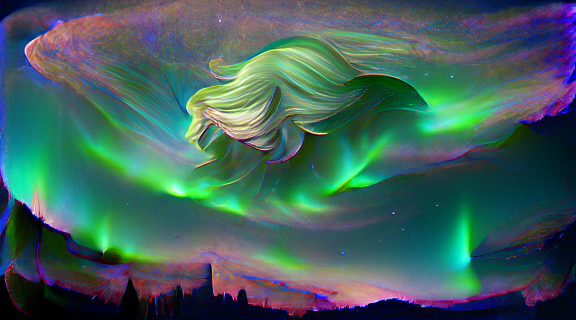

iter: 300, finished (-16=>2.42)


In [ ]:
#@title NASART Gradio UI
import gradio as gr
import torch
import pixray

#defining the main function
def generate(prompt, quality, generator, aspect):
  torch.cuda.empty_cache()
  pixray.reset_settings()

  #Add settings
  pixray.add_settings(prompts=prompt,
                      quality=quality,
                      aspect=aspect,
                      drawer=generator)
  pixray.add_settings(display_clear=True)

#Apply these settings and run
  settings = pixray.apply_settings()
  pixray.do_init(settings)
  pixray.do_run(settings)

  return 'output.png'

#creating the UI
prompt = gr.inputs.Textbox(default="The Big Bang", label="Text Prompt")
quality = gr.inputs.Radio(choices=['draft', 'normal', 'better'], label= "Quality")
generator = gr.inputs.Radio(choices=['vqgan', 'clipdraw'], label= "Image Generator")
aspect = gr.inputs.Radio(choices=['square', 'widescreen','portrait'], label="Size")

# Launch the demo
iface = gr.Interface(generate, title = "NASART AI by Argonauts", description = "A prototype AI program that uses the given text prompt to generate creative space related artwork.",
                     inputs=[prompt, quality, generator, aspect], outputs=['image'], enable_queue=True, live=False)
iface.launch(debug=True)